In [1]:
# Import all the libraries
import pandas as pd
import numpy as np
import scipy as sp
import scipy.stats
pd.options.mode.chained_assignment = None  # default='warn', Mutes warnings when copying a slice from a DataFrame.
pd.set_option('display.max_columns', None)
import glob
import datetime
import os
import json
from io import StringIO
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import RegexpTokenizer
from nltk.util import bigrams
from nltk.corpus import stopwords
from nltk.corpus import wordnet
import nltk
%matplotlib inline

C:\Users\nspace\Anaconda3\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


### Sampling and loading the data
For this exploratory analysis we used the Spark cluster to randomly sample the data with the `sample_data.py` script and retrieved the metadata entries for the items that appear in our samples by writing the product IDs to a text file one per line and using the `get_metadata.py` script.

In [2]:
# Paths to the data and metadata folders.
DATA_FOLDER = 'data/'
META_FOLDER = DATA_FOLDER + 'meta/'

In [3]:
# Load one data file
def load_one_file(path):
    with open(path) as f:
        return [json.loads(line) for line in f]

# Load one metadata file. The rows aren't proper JSON
# but they can be parsed using python's eval function
# as per the dataset's web page.
def load_one_meta_file(path):
    with open(path) as f:
        return [eval(line) for line in f]

# The sample we extracted is still too large, so we'll only use the first 100 files
data_files = glob.glob(DATA_FOLDER + 'part-000*')
data = sum(map(load_one_file, data_files), [])

# Create the first dataframe
df = pd.DataFrame(data)

# Write the product IDs to a .csv files, one per line.
# Used to get metadata using the cluster.
# df[['asin']].to_csv('asin_lookup.csv', index=False, header=False)

# The meta folder contains metadata for all the items we were interested in.
meta_files = glob.glob(META_FOLDER + '*')
meta = sum(map(load_one_meta_file, meta_files), [])

# Create the second dataframe
meta_df = pd.DataFrame(meta)

In [4]:
# Join the dataframes. Since our analysis relies on the metadata for a good part
# we have to remove any reviews for which metadata is not available.
joined = pd.merge(df, meta_df, how='inner')

# Parse the review time as a DateTime and add review month and year columns
joined['reviewTime'] = pd.to_datetime(joined.unixReviewTime, unit='s')
joined['reviewMonth'] = joined.reviewTime.map(lambda t: t.month)
joined['reviewYear'] = joined.reviewTime.map(lambda t: t.year)

# We don't want any reviews for which the price is either NaN or 0
# or which don't belong to any category
joined = joined.dropna(axis=0, subset=['categories', 'price', 'reviewText'])
joined = joined[joined.price != 0 & (len(joined.reviewText) > 0)]

### Adding features
#### Sentiment scores
Thre are several options to do sentiment analysis: clustering, training a classifier on an existing corpus of labeled data or using a pre-trained one. We used [VADER](https://github.com/cjhutto/vaderSentiment), a pre-trained sentiment score analyzer tuned for messages that tipically appear on social media to give each review text a series of sentiment scores. The reasons behind our choice are that training a classifirer is time consuming and that VADER is trained on text snippets similar to those in our dataset, including some from Amazon reviews.

In [5]:
analyzer = SentimentIntensityAnalyzer()

# Example
print(joined.iloc[10]['reviewText'])
analyzer.polarity_scores(joined.iloc[10]['reviewText'])

So creative and funny. Loved the many twists and turns of this story and the clever way in which the author wove history into the craziness that was this man's life!


{'compound': 0.899, 'neg': 0.062, 'neu': 0.617, 'pos': 0.321}

In [6]:
# Add the sentiment score columns to the dataframe
comp_score = joined.reviewText.apply(lambda t: analyzer.polarity_scores(t))
joined['compound_score'] = comp_score.apply(lambda s: s['compound'])
joined['positive_score'] = comp_score.apply(lambda s: s['pos'])
joined['negative_score'] = comp_score.apply(lambda s: s['neg'])
joined['neutral_score'] = comp_score.apply(lambda s: s['neu'])

In [7]:
# Each non-empty sales rank is a dictionary that maps exactly one
# category to exactly one ranking
joined['salesRankPosition'] = joined.salesRank.apply(lambda r: list(r.values())[0]
                                                     if r and isinstance(r, dict) else np.nan)
joined['salesRankCategory'] = joined.salesRank.apply(lambda r: list(r.keys())[0]
                                                     if r and isinstance(r, dict) else np.nan)

#### Word counts
We measured the number of words that make up a review as an indicator of the review's complexity.

In [8]:
# Word tokenizer
tokenizer = RegexpTokenizer(r'\w+')

# Add tokenized text and word cound to the dataframe
joined['tokenized_text'] = joined.reviewText.apply(tokenizer.tokenize)
joined['word_count'] = joined.tokenized_text.apply(len)

#### Main category
Each item in the dataset has a `categories` field which, when not absent, is an array of arrays of strings. Each item can belong to an arbitrary number of categories some of which are subcategories of a larger category. We will first flatten these arrays of arrays in order to make subsequent processing easier.

In [9]:
# Flatten the categories
joined['categories_flat'] = joined.categories.apply(lambda a: [i for sa in a for i in sa])
# Remove rows with no categories
joined = joined[[(c and bool(c[0])) for c in joined.categories_flat]]

In order to be able to plot aggregate values for each category we need to pick one category for each product that we will use as its main category. We built a dictionary that maps the most common categories to the main category and assigned a main category to each item according to which of these common categories it belongs to. In order to build this dictionary we started from the list of categories that the maintainer of the dataset offers separate files for and added more until we could cover almost all the items.

In [10]:
# Load category dictionary from file
categories_dict = None
with open('categories_dict.json') as f:
    categories_dict = json.load(f)

In [11]:
# Function that returns an item's main category according
# to the above dictionary, or NaN if none of its categories appear in the dictionary.
def get_main_category(categories):
    for c in categories:
        if c in categories_dict:
            return categories_dict[c]

    return np.nan

# Derive each product's main category
joined['main_category'] = joined.categories_flat.apply(lambda a: get_main_category(a))

# Remove items for which there is no category
joined = joined.dropna(axis=0, subset=['main_category'])

Even though this is not explained in the dataset's documentation we can see that in all but one review the second element of the `helpful` field is greater or equal than the first. Thus we assume that the first element is the number of users that rated the review as helpful and the second one is the total number of ratings that the review received.

In [12]:
# Number of times that the review was voted as helpful
joined['helpful_pos'] = joined.helpful.apply(lambda a: a[0])

# Total number of votes that the review received
joined['helpful_tot'] = joined.helpful.apply(lambda a: a[1])

# Ratio of helpful votes to total votes
joined['helpful_ratio'] = joined.helpful.apply(lambda a: a[0] / a[1] if a[1] else np.nan)

We split the prices in tiers to run some of the comparisons.

In [13]:
# Arbitrarily chosen
price_bins = [
    0,
    10,
    20,
    30,
    40,
    50,
    60,
    70,
    80,
    90,
    100,
    200,
    500,
    1000
]

joined['price_tier'] = pd.cut(joined.price, price_bins)

In [14]:
# Final dataframe
joined.head()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,brand,categories,description,imUrl,price,related,salesRank,title,reviewMonth,reviewYear,compound_score,positive_score,negative_score,neutral_score,salesRankPosition,salesRankCategory,tokenized_text,word_count,categories_flat,main_category,helpful_pos,helpful_tot,helpful_ratio,price_tier
2,B00E7OIOVC,"[0, 0]",5.0,Great!,2014-07-03,A0001528BGUBOEVR6T5U,igozingo,Five Stars,1404345600,niceEshop,"[[Home & Kitchen, Kitchen & Dining, Kitchen Ut...",Style flask funnel great to help you fill your...,http://ecx.images-amazon.com/images/I/31gMKQdA...,1.99,"{'also_bought': ['B004TQIB7U', 'B006O1EBHW', '...",{'Kitchen & Dining': 63021},niceEshop(TM) Small Stainless Steel Funnel For...,7,2014,0.6588,1.000,0.000,0.000,63021.0,Kitchen & Dining,[Great],1,"[Home & Kitchen, Kitchen & Dining, Kitchen Ute...",Home & Kitchen,0,0,NaN,"(0, 10]"
3,B00EXOZ9W8,"[0, 0]",5.0,"My man was more then happy with it, looking fo...",2014-07-02,A00030342K9JCQO8Q7C3L,Joseph Dvorak,Five Stars,1404259200,NaN,"[[Home & Kitchen, Kitchen & Dining, Small Appl...",,http://ecx.images-amazon.com/images/I/41Oc0HaP...,65.81,"{'also_bought': ['B000FAJ0K6', 'B0012UY6XO', '...",{'Kitchen & Dining': 56153},BELLA 14025 Programmable Slow Cooker with Lock...,7,2014,0.7893,0.349,0.000,0.651,56153.0,Kitchen & Dining,"[My, man, was, more, then, happy, with, it, lo...",14,"[Home & Kitchen, Kitchen & Dining, Small Appli...",Home & Kitchen,0,0,NaN,"(60, 70]"
4,1477473939,"[0, 0]",4.0,Reading this seriers was a amazing. It was ver...,2013-01-26,A000443821AD43TOGKNGZ,Uluwehi,Really enjoyed it!,1359158400,NaN,[[Books]],USA Today Best Selling Author Elizabeth Reyes...,http://ecx.images-amazon.com/images/I/51bhuPCO...,4.99,"{'also_bought': ['147522186X', '1475244207', '...",{'Books': 1011147},Making You Mine: The Moreno Brothers,1,2013,0.9199,0.353,0.000,0.647,1011147.0,Books,"[Reading, this, seriers, was, a, amazing, It, ...",31,[Books],Books,0,0,NaN,"(0, 10]"
5,1477473939,"[0, 0]",4.0,"I haven't read any of this series before, but ...",2013-04-09,A1BAWRQQMC7L72,Roswellfan410,Really liked it,1365465600,NaN,[[Books]],USA Today Best Selling Author Elizabeth Reyes...,http://ecx.images-amazon.com/images/I/51bhuPCO...,4.99,"{'also_bought': ['147522186X', '1475244207', '...",{'Books': 1011147},Making You Mine: The Moreno Brothers,4,2013,0.9548,0.411,0.000,0.589,1011147.0,Books,"[I, haven, t, read, any, of, this, series, bef...",35,[Books],Books,0,0,NaN,"(0, 10]"
6,B0092QSQ3Q,"[0, 0]",5.0,It is really good! But it was hard to push out...,2012-11-03,A00044782UB564I4SGA0X,Johan98,Really good!,1351900800,NaN,"[[Cell Phones & Accessories, Accessories, Scre...",Protect your InvestmentDaily use of your mobil...,http://ecx.images-amazon.com/images/I/51722Hcw...,5.95,"{'also_bought': ['B00FDXLRM4', 'B009VO0506', '...",{'Cell Phones & Accessories': 4377},Skinomi&reg; TechSkin - Apple iPhone 5 Screen ...,11,2012,0.6534,0.228,0.056,0.716,4377.0,Cell Phones & Accessories,"[It, is, really, good, But, it, was, hard, to,...",22,"[Cell Phones & Accessories, Accessories, Scree...",Electronics,0,0,NaN,"(0, 10]"


In [15]:
# See how many reviews are left
print('Remaining reviews: {}'.format(joined.shape[0]))

Remaining reviews: 125958


### Error bars with bootstrap resampling
When plotting aggregate statistics for a group, such as the mean score, we need to include error bars in the plot. We used bootstrap resampling to derive confidence intervals for those statistics since the underlying distribution of the data is unknown to us in general.

All the error bars that we used in our analysis are 95% confidence intervals obtained using this method.

In [16]:
def bootstrap_estimate(data, func):
    """Calculate a bootstrap estimate of a certain function of a sequence
    This function draws a random sample with replacement from a list and
    uses func to calculate a statistic over that sample.
    Since the sample is drawn with replacement each element of the list
    may appear multiple times or not appear at all in the sample.
    """
    n = len(data)
    
    # Generate n random indices with replacement
    indices = np.random.randint(n, size=n)
    
    # Sample the data
    sample = data.iloc[indices]

    # Compute the statistic
    return func(sample)

def confidence_interval(data, count, func, confidence=0.95):
    """Return a statistic and its confidence interval of a sequence using bootstrap resampling.
    Computes the statistic over count bootstrap samples drawn from the data, then computes the 
    lower and uppper bounds of the confidence interval.
    """
    estimates = [bootstrap_estimate(data, func) for _ in range(count)]
    
    # Debug: verify that the estimates have a normal distribution
    # plt.hist(estimates, bins=50)
    
    # Calculate the confidence interval bounds assuming a normal distribution in
    # the estimates
    m, se = np.mean(estimates), np.std(estimates)
    lower, upper = scipy.stats.norm.interval(confidence, loc=m, scale=se)
    
    return m, lower, upper

def plot_groupby_error_bars(grouped, count, func, ax, confidence=0.95):
    """Plot a bar plot showing the result of a statistic applied to the groups
    of a groupby object and use count bootstrap samples to compute confidence intervals
    """
    out = grouped.agg(lambda a: confidence_interval(a, count, func, confidence))
    means = out.apply(lambda x: x[0] if x else 0)
    mins = out.apply(lambda x: x[1] - x[0] if x else 0)
    maxs = out.apply(lambda x: x[2] - x[0] if x else 0)

    errs = np.c_[mins, maxs].T
    means.plot(kind='bar', ax=ax, yerr=errs, ecolor='r')

In [17]:
# Example: 95% confidence interval of the mean of the review scores with
# 1000 bootstrap samples. 
confidence_interval(joined.overall, 1000, np.mean)

(4.1890776449292622, 4.1821743697331799, 4.1959809201253444)

### Feature analysis
We can now start to have a look at the distribution of the various features. First of all: overall score distribution.

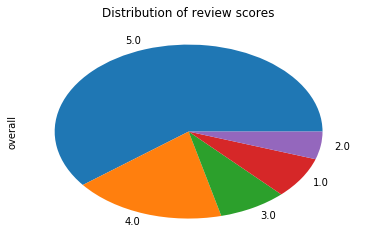

In [18]:
# Overall distribution
joined.overall.value_counts().plot(kind='pie', title='Distribution of review scores')

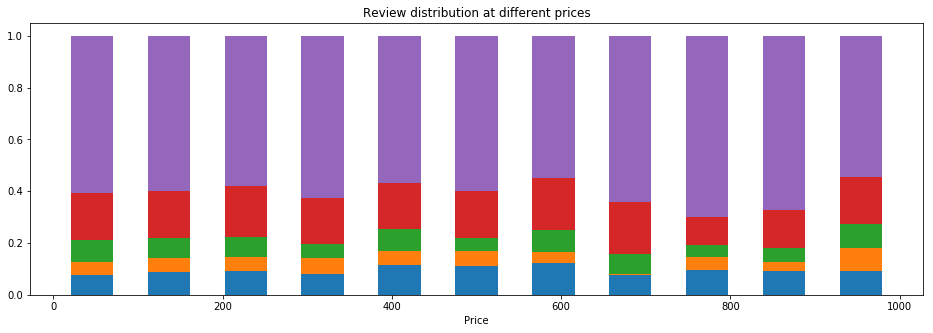

In [19]:
# Distribution with respect to price
_, ax1 = plt.subplots(1, 1, figsize=(16,5))
ax1.set_title('Review distribution at different prices')
ax1.set_xlabel('Price')

# Divide the reviews in uniformly sized bins according to the item's price
bins = np.linspace(0, 1000, 12)
gb = joined.groupby('overall')
series = np.array([np.histogram(gb.get_group(i).price.values, bins=bins)[0] for i in range(1, 6)])

# Make the total height of the bars equal 1
series = series / series.sum(axis=0)
histbins = bins[:-1] + np.ediff1d(bins) / 2
bottom = np.zeros(series.shape[1])

for i in range(series.shape[0]):
    ax1.bar(histbins, series[i], width=50, bottom=bottom)
    bottom += series[i]

We can see that more than half of the reviews gave five stars to the product independently of the price. The low proportion of 1 and 2 star reviews suggests that customers are very likely to be satisfied with the product they purchased.

Let's now consider the number of reviews by month of the year.

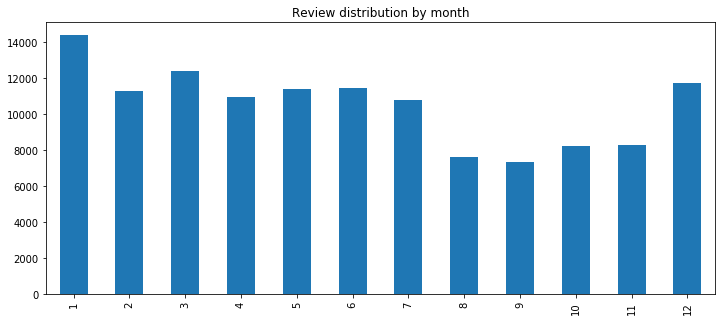

In [20]:
_, ax = plt.subplots(figsize=(12,5))
joined.reviewMonth.value_counts().sort_index().plot(ax=ax, kind='bar', title='Review distribution by month')

The number of reviews seems to be highest during winter and spring and lower during autumn, with January being the month with the highest number of reviews. The biggest shopping time in the year is during the christmas holidays and we imagine that reviews are written the next month after the product has been used for some time.

We can now start looking at the prices of the items.

In [21]:
# Group the items by price tier
group_by_price_tier = joined.groupby('price_tier')

First of all we can plot the distribution of the prices of reviewed items.

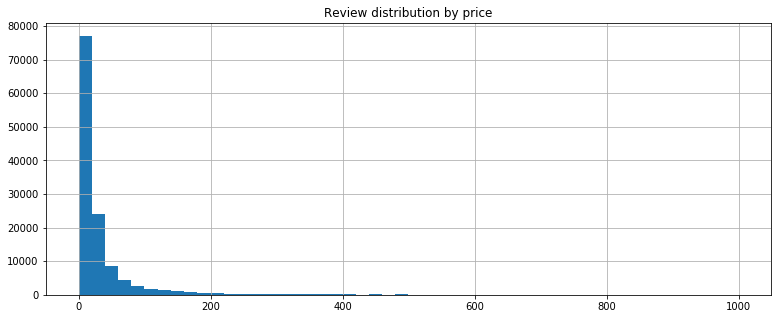

In [22]:
_, ax = plt.subplots(figsize=(13,5))
ax.set_title('Review distribution by price')
joined.price.hist(bins=50, ax=ax)

The distribution seems to be heavy tailed, with very cheap items making up the majority of the reviews. We can verify if this distribution follows a power law by plotting it on a log-log scale.

In [23]:
# We need to make logarithmic bins ourselves.
# _, ax = plt.subplots(figsize=(13,5))

# ax.set_xscale('log')
# ax.set_title('Review distribution by price')
# joined.price.hist(ax=ax, log=True, bins=log_bins)

The distribution doesn't follow a linear relationship on a log-log plot so the distribution is not a power law.

Now let's see the distribution according to the price tiers we defined above.

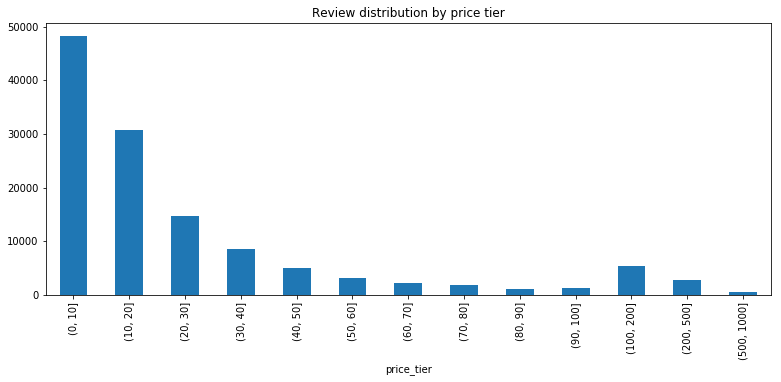

In [24]:
_, ax = plt.subplots(figsize=(13,5))

ax.set_title('Review distribution by price tier')

group_by_price_tier.size().plot(kind='bar', ax=ax)

One of the hypotheses we want to verify is whether the price of an item correlates with its review score, more specifically whether items belonging to a higher price tier are more likely to get better reviews. We can verify that by computing the mean review score for each price tier and displaying that on a bar plot.

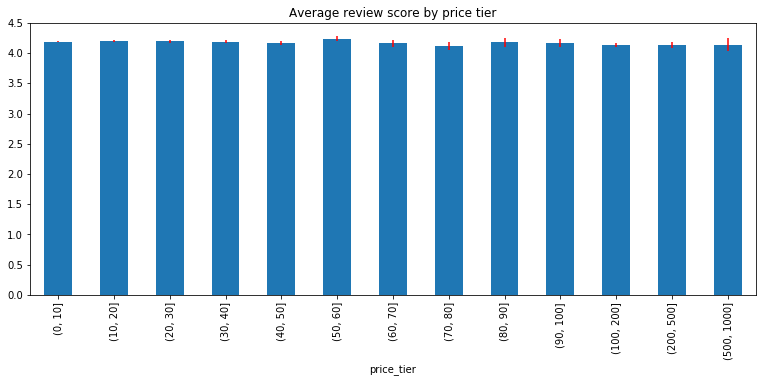

In [25]:
_, ax = plt.subplots(figsize=(13,5))

ax.set_title('Average review score by price tier')

plot_groupby_error_bars(group_by_price_tier.overall, 1000, np.mean, ax=ax)

There seems to be no correlation between an item's price tier and its mean score. We did not look at the medians since more than half of the reviews give 5 stars to the item in all price tiers and thus the median would always be 5.

We can also verify whether the month during which a review was written correlates with its score. The presence of such a correlation could indicate that buyers are more likely to give a better review in certain periods of the year than others.

In [26]:
# Group data by the month in which the review was written.
group_by_month = joined.groupby('reviewMonth')
overall_month = group_by_month.overall

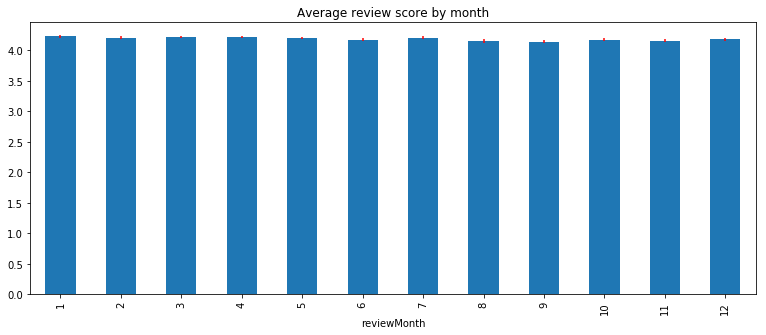

In [27]:
_, ax = plt.subplots(figsize=(13,5))
ax.set_title('Average review score by month')

plot_groupby_error_bars(overall_month, 1000, np.mean, ax)

Again, we can see that the correlation we hypothesized does not exist in the data. The review scores seem to be independent of the month in which they were written.

Let's now look at the items grouped by their category

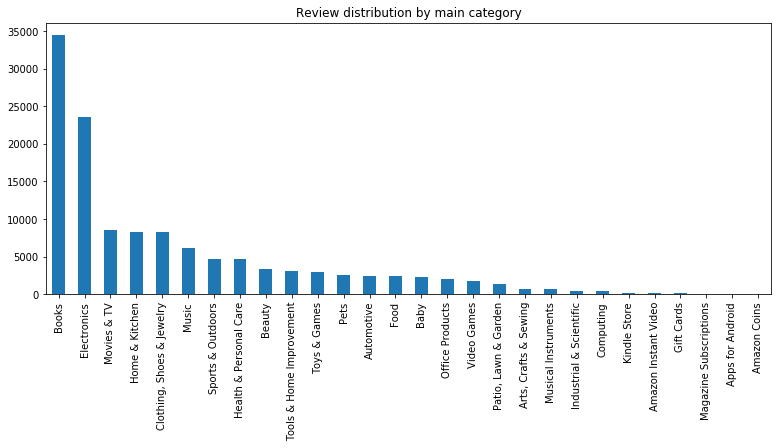

In [28]:
_, ax = plt.subplots(figsize=(13,5))
ax.set_title('Review distribution by main category')

joined.main_category.value_counts().plot(kind='bar', ax=ax)

In [29]:
pd.DataFrame({
    'All reviews': joined.main_category.value_counts(),
}).sort_values('All reviews', ascending=False)

,All reviews
Books,34391
Electronics,23594
Movies & TV,8488
Home & Kitchen,8340
"Clothing, Shoes & Jewelry",8326
Music,6197
Sports & Outdoors,4747
Health & Personal Care,4640
Beauty,3404
Tools & Home Improvement,3046


The most popular categories by a large margin seem to be books and electronics. The least popular categories have very few reviews in our sample so the results we get from them might not be very relevant.

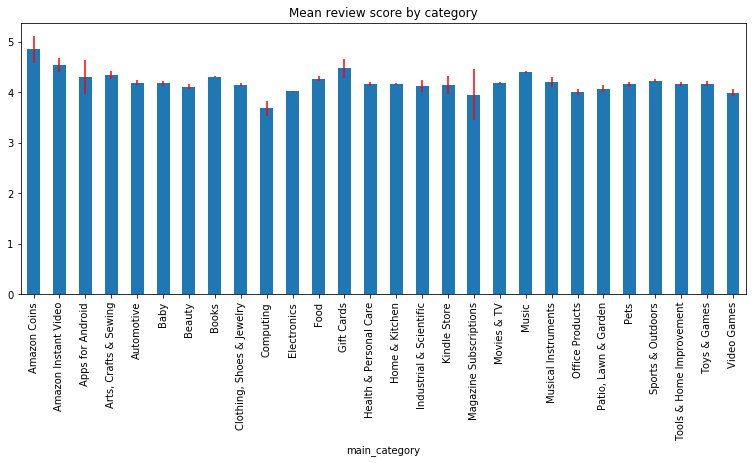

In [30]:
_, ax = plt.subplots(figsize=(13,5))
by_category = joined.groupby('main_category')

ax.set_title('Mean review score by category')

plot_groupby_error_bars(by_category.overall, 1000, np.mean, ax)

We can see from here that products belonging to certain categories indeed tend to receive better reviews on average.

We can also look at the relationship between the overall rating given in a review and the overall sentiment score of the description. We expect negative reviews to have a sentiment score closer to -1 and vice versa. The sentiment classifier we chose assigns 4 scores to each review text: positive score, negative score, neutral score and a normalized compound score. Negative, positive and neutral scores go from 0 to 1 and compound score goes from -1 (most negative) to 1 (most positive) where scores between -0.5 and 0.5 are considered neutral.

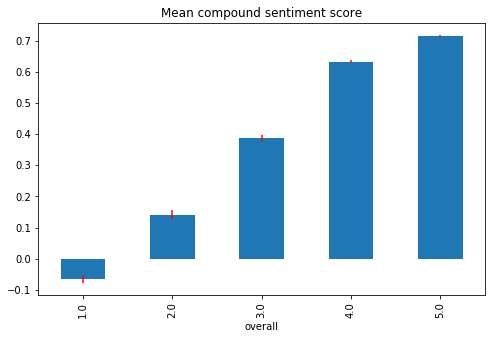

In [31]:
by_overall = joined.groupby('overall')

_, ax = plt.subplots(figsize=(8,5))
ax.set_title('Mean compound sentiment score')
plot_groupby_error_bars(by_overall.compound_score, 1000, np.mean, ax)

Our expectations were correct: negative reviews indeed have a lower sentiment score, but even the 1 star reviews do not seem to have a strongly negative connotation. Perhaps overly rude or angry reviews are removed by Amazon's staff.

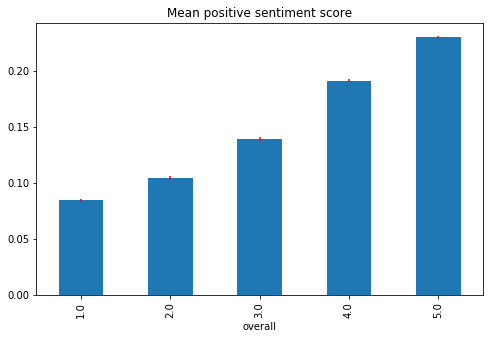

In [32]:
_, ax = plt.subplots(figsize=(8,5))
ax.set_title('Mean positive sentiment score')

plot_groupby_error_bars(by_overall.positive_score, 1000, np.mean, ax)

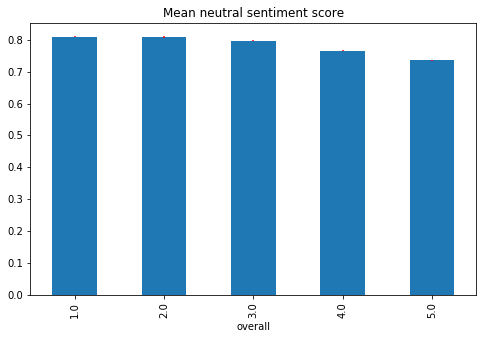

In [33]:
_, ax = plt.subplots(figsize=(8,5))
ax.set_title('Mean neutral sentiment score')

plot_groupby_error_bars(by_overall.neutral_score, 1000, np.mean, ax)

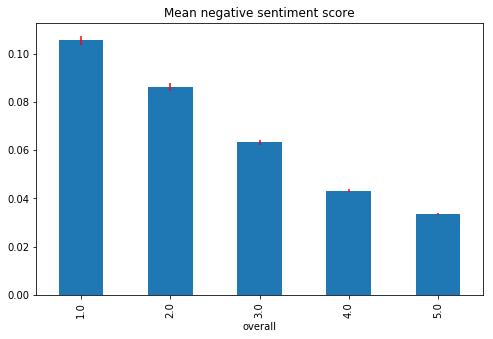

In [34]:
_, ax = plt.subplots(figsize=(8,5))
ax.set_title('Mean negative sentiment score')

plot_groupby_error_bars(by_overall.negative_score, 1000, np.mean, ax)

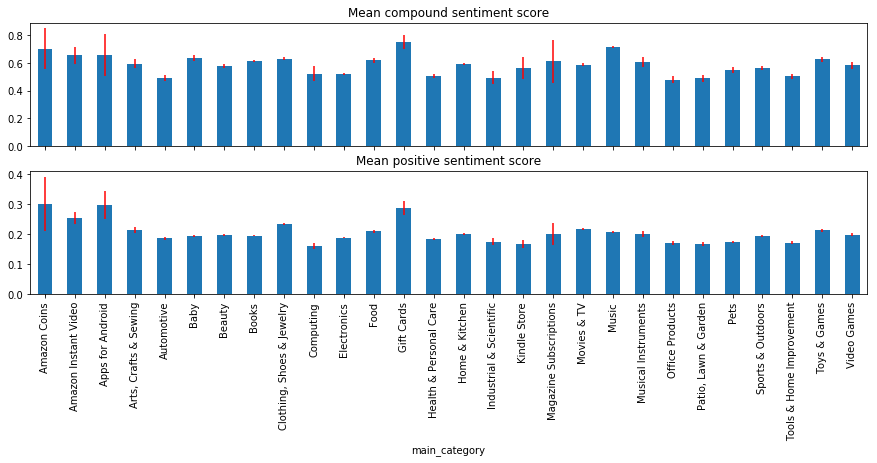

In [35]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15, 5))
ax1.set_title('Mean compound sentiment score')
plot_groupby_error_bars(by_category.compound_score, 1000, np.mean, ax1)

ax2.set_title('Mean positive sentiment score')
plot_groupby_error_bars(by_category.positive_score, 1000, np.mean, ax2)

The negative, positive and neutral sentiment scores confirm what we saw by observing the compound score. Like with ratings, some categories such as gift cards, music, baby, toys and games have a higher compound or positive semtiment score even though none of them is very different from the others. Gift cards also has very few reviews so its score is not reliable.

We verify whether an item's price is correlated to its sentiment score.

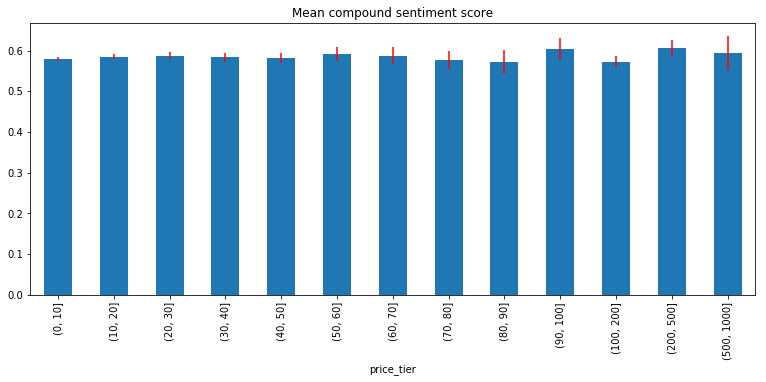

In [36]:
fig, ax = plt.subplots(figsize=(13, 5))
ax.set_title('Mean compound sentiment score')
plot_groupby_error_bars(group_by_price_tier.compound_score, 1000, np.mean, ax)

A more positive sentiment score doesn't correlate with a higher price.

We tried to verify whether the sentiment score of the reviews of a product correlates with its sales ranking

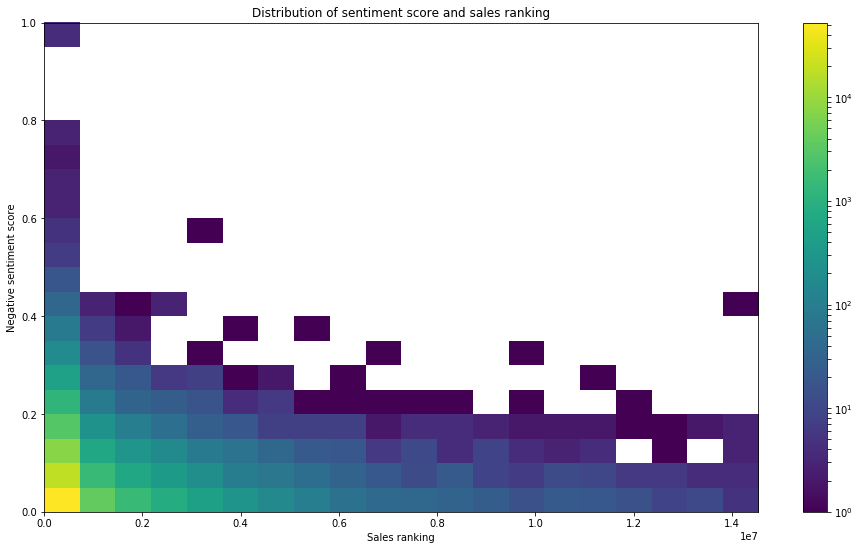

In [37]:
fig, ax = plt.subplots(figsize=(16, 9))
onlyranked = joined.dropna(subset=['salesRankPosition'])

r = ax.hist2d(onlyranked.salesRankPosition, onlyranked.negative_score, bins=20, norm=LogNorm())
ax.set_title('Distribution of sentiment score and sales ranking')
ax.set_xlabel('Sales ranking')
ax.set_ylabel('Negative sentiment score')
fig.colorbar(r[3])

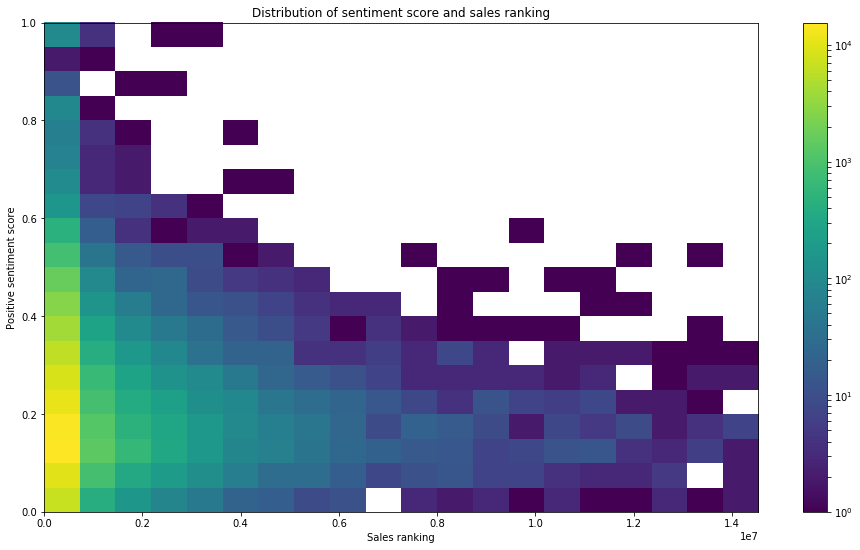

In [38]:
fig, ax = plt.subplots(figsize=(16, 9))
img = ax.hist2d(onlyranked.salesRankPosition, onlyranked.positive_score, bins=20, norm=LogNorm())
ax.set_title('Distribution of sentiment score and sales ranking')
ax.set_xlabel('Sales ranking')
ax.set_ylabel('Positive sentiment score')
fig.colorbar(img[3])

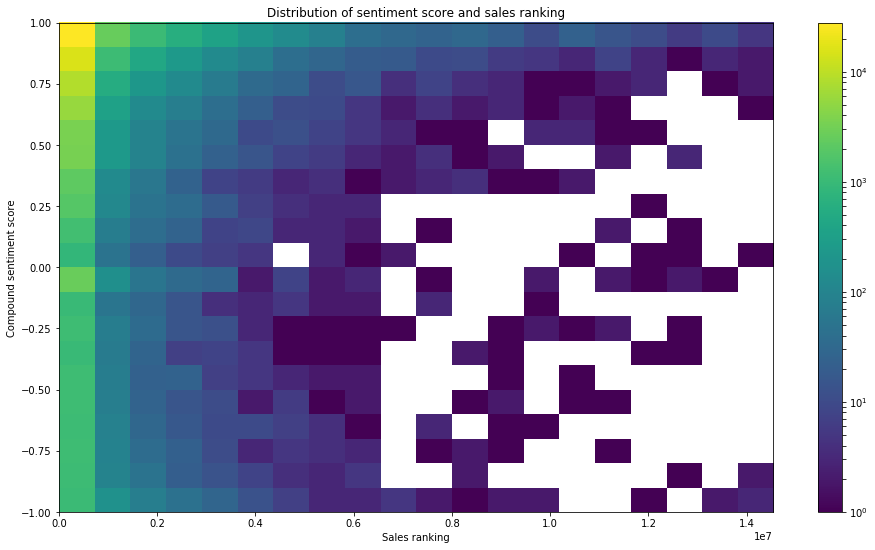

In [39]:
fig, ax = plt.subplots(figsize=(16, 9))
img = ax.hist2d(onlyranked.salesRankPosition, onlyranked.compound_score, bins=20, norm=LogNorm())
ax.set_title('Distribution of sentiment score and sales ranking')
ax.set_xlabel('Sales ranking')
ax.set_ylabel('Compound sentiment score')
fig.colorbar(img[3])

The sales ranking of a product and the sentiment score of its reviews don't seem to be correlated: from the above plots we can see that the items that have the most reviews are those higher up in the sales ranking which is expected since they are more likely to appear in user searches but also that the overall distribution of the sentiment scores doesn't change with the sales ranking.

We tried comparing the length of the reviews to the price tier of the items being reviewed: our theory is that customers that purchase a more expensive item are more likely to write a more detailed review. We observed that this doesn not happen when looking at the dataset as a whole but only when looking at some categories, such as electronics individually.

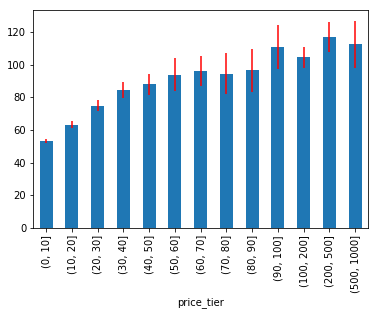

In [40]:
gb = joined[joined.main_category == 'Electronics'].groupby('price_tier').word_count
ax = plt.subplot()
plot_groupby_error_bars(gb, 1000, np.mean, ax)

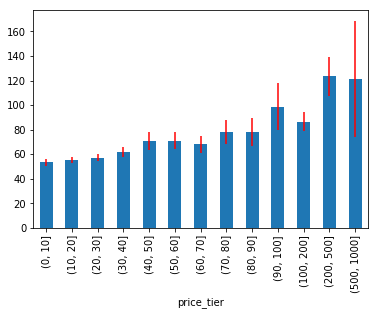

In [41]:
gb = joined[joined.main_category == 'Home & Kitchen'].groupby('price_tier').word_count
ax = plt.subplot()
plot_groupby_error_bars(gb, 1000, np.mean, ax)

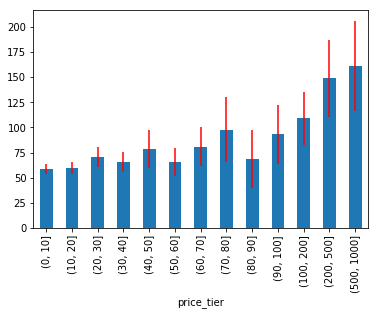

In [42]:
gb = joined[joined.main_category == 'Office Products'].groupby('price_tier').word_count
ax = plt.subplot()
plot_groupby_error_bars(gb, 1000, np.mean, ax)

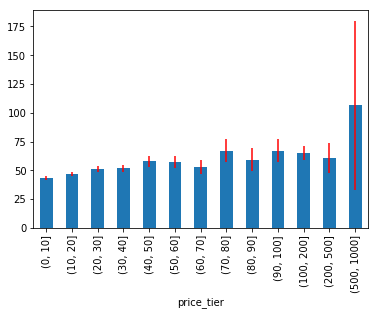

In [43]:
gb = joined[joined.main_category == 'Clothing, Shoes & Jewelry'].groupby('price_tier').word_count
ax = plt.subplot()
plot_groupby_error_bars(gb, 1000, np.mean, ax)

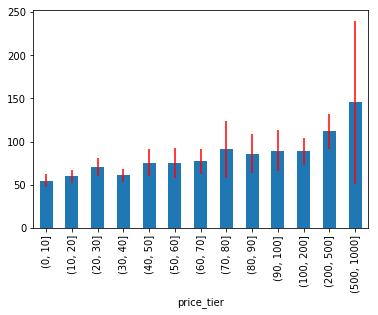

In [44]:
gb = joined[joined.main_category == 'Patio, Lawn & Garden'].groupby('price_tier').word_count
ax = plt.subplot()
plot_groupby_error_bars(gb, 1000, np.mean, ax)

### Observations
In the abstract for our project we planned to investigate whether factors such as a product's price or the season in which a review is written can affect the score given to a product. When analyzing the dataset we found that such correlations seem to be absent in the data and the only other feature that correlates with the review's score is the sentiment score (positive or negative) that the review's extended summary expresses. Furthermore we have discovered that in some of the categories the length of the review positively correlates with the price tier of the product, suggesting that users might write more detailed reviews for products that they spent more money on. It seems that just looking at the numbers in the data doesn't tell us too much about what we want to know and we might need to conduct further analysis on the text of the reviews or the features of the product (such as looking at what other items are related to the one being reviewed or seeing if we can predict whether a review is going to be more useful according to which words the author uses and how high the sentimental score of the review is. 

### Future Direction:

We struggled to find significant correlations with the price, time, salesRank factors on user reviews, as we had initially proposed. However, we became more interested in learning about how incentivization can impact how reviewers write their reviews and how products are rated. The following is a glimpse into a couple interesting leads we have to understand the influence of incentivization on review quality.

In [45]:
# Using keywords in incentivized reviews (i.e., "I received xxx product for free in exchange for an honest, 
# unbiased review"), we separate the incentivized reviews from those that are not incentivized. 
mask = joined['reviewText'].map(lambda x: ('unbiased review' in x) or ('honest review' in x) or ('in exchange for' in x) or ('disclaimer' in x))
incentivized = joined[mask]
non_incentivized = joined[~mask]

In [46]:
# This is an example of a so-called "unbiased review"
print('Incentivized Review example: ')
incentivized.iloc[20]['reviewText']

Incentivized Review example: 


'Liss Thomas creates a fascinating and intriguing world within the fairly short contents of this novel. There is magic, mythical creatures, and imaginative creations. The idea is a different twist on the monsters under our beds. The characters are easy to form attachments with, though in no way perfect, making them easier to believe.It is simply written but not to the point of treating the reader like a child, making it a fast, easy, and enjoyable read. My only complaint would be that it was much too short. I will definitely be purchasing the next instalment.This novel was given to me in exchange for an honest review. All opinions stated are entirely my own.  To view more please visit me at [...]'

In [47]:
# Sizes of incentivized samples vs non.
print(non_incentivized.shape)
print(incentivized.shape)

(125610, 33)
(348, 33)


In [48]:
print("incentivized overall rating: ", incentivized['overall'].mean())
print("non_incentivized overall rating: ", non_incentivized['overall'].mean())

incentivized overall rating:  4.301724137931035
non_incentivized overall rating:  4.188734973330149


Frequency of Star Ratings of Incentivized Reviews


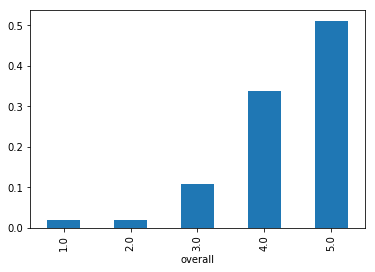

Histogram of Review Text Sentiment Scores for Incentivized Reviews


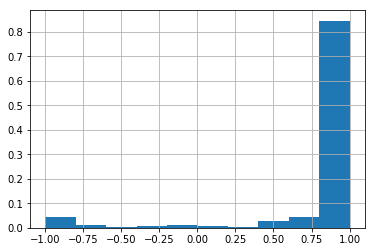

Frequency of Star Ratings of Non-Incentivized Reviews


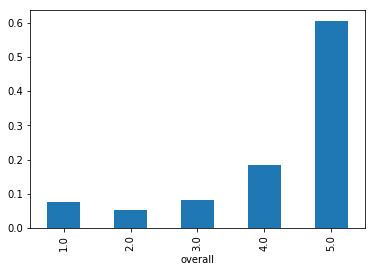

Histogram of Review Text Sentiment Score for Non-Incentivized Reviews


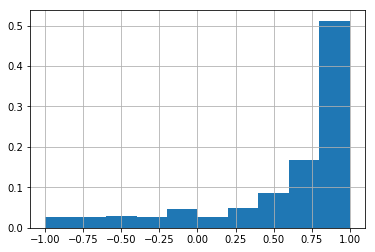

In [49]:
print('Frequency of Star Ratings of Incentivized Reviews')
(incentivized.groupby('overall').size()/incentivized.shape[0]).plot(kind = 'bar')
plt.show()
print('Histogram of Review Text Sentiment Scores for Incentivized Reviews')
incentivized['compound_score'].hist(weights = [1/incentivized.shape[0]]*incentivized.shape[0])
plt.show()
print('Frequency of Star Ratings of Non-Incentivized Reviews')

(non_incentivized.groupby('overall').size()/non_incentivized.shape[0]).plot(kind = 'bar')
plt.show()
print('Histogram of Review Text Sentiment Score for Non-Incentivized Reviews')

non_incentivized['compound_score'].hist(weights = [1/non_incentivized.shape[0]]*non_incentivized.shape[0])
plt.show()

Although, the sizes of the two sets of reviews is very different, and we do not have nearly as many for the incentivized set compared to the non-incentivized set, we can still make some conclusions on how people, who are given products for free or at a discount, write their reviews. Using the vader sentiment analyzer, we can see that incentivized reviews are much more positive that non-incentivized. In addition, people who are given products for free/discounted give more positive ratings and less 1 or 2-star ratings. Our plan to further analyze this phenomenon is detailed in the readme.

# Final milestone

### Better text analysis
Our first step in our analysis of incentivized reviews was to search for a better method of finding them in our dataset. Matching on exact substrings is likely to yield many false negatives so our first idea was to do some processing on the text: we took inspiration from the tutorial on processing text and first of all performed lemmatization using nltk's default part-of-speech tagger and WordNet.

In [18]:
def get_wordnet_pos(treebank_tag):
    """
    Taken from the tutorial on text processing
    Cf. https://stackoverflow.com/questions/15586721/wordnet-lemmatization-and-pos-tagging-in-python
    :param treebank_tag: a tag from nltk.pos_tag treebank
    """
    
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [19]:
wnl = nltk.WordNetLemmatizer()
stops = set(stopwords.words('english'))

In [20]:
# Example
tokens = ['I', 'received', 'this', 'product', 'for', 'free', 'or', 'at', 'a', 'discount', 'in', 'exchange',
          'for', 'my', 'honest', 'unbiased', 'review']
# Add part-of-speech tags
pos = [(t, p) for t, p in nltk.pos_tag(tokens) if t.lower() not in stops]
# Lemmatize using part-of-speech tags
[wnl.lemmatize(t,pos=get_wordnet_pos(p)) for t,p in pos]

['receive',
 'product',
 'free',
 'discount',
 'exchange',
 'honest',
 'unbiased',
 'review']

Simply looking for words like "unbiased" or "exchange" would yield too many false positives: we can further improve the accuracy of our analysis by using bigrams. We analyzed the reviews in the subsample of the data and manually built a list of bigrams that are common in incentivized reviews but absent from others.

In [21]:
def filter_func(tokens, stops):
    pos = [(t, p) for t, p in nltk.pos_tag(tokens) if t.lower() not in stops]
    lem = [wnl.lemmatize(t,pos=get_wordnet_pos(p)) for t,p in pos]
    bg = set(bigrams(lem))

    return (('complimentary', 'copy') in bg) or \
           (('discount', 'exchange') in bg) or \
           (('exchange', 'product') in bg) or \
           (('exchange', 'review') in bg) or \
           (('exchange', 'unbiased') in bg) or \
           (('exchange', 'free') in bg) or \
           (('exchange', 'honest') in bg) or \
           (('exchange', 'true') in bg) or \
           (('exchange', 'truth') in bg) or \
           (('fair', 'review') in bg) or \
           (('free', 'discount') in bg) or \
           (('free', 'exchange') in bg) or \
           (('free', 'sample') in bg) or \
           (('free', 'unbiased') in bg) or \
           (('honest', 'feedback') in bg) or \
           (('honest', 'unbiased') in bg) or \
           (('opinion', 'state') in bg) or \
           (('opinion', 'own') in bg) or \
           (('provide', 'exchange') in bg) or \
           (('provide', 'sample') in bg) or \
           (('provided', 'sample') in bg) or \
           (('provided', 'exchange') in bg) or \
           (('receive', 'free') in bg) or \
           (('receive', 'free') in bg) or \
           (('received', 'free') in bg) or \
           (('received', 'sample') in bg) or \
           (('return', 'unbiased') in bg) or \
           (('review', 'sample') in bg) or \
           (('sample', 'product') in bg) or \
           (('sample', 'unbiased') in bg) or \
           (('sample', 'free') in bg) or \
           (('send', 'sample') in bg) or \
           (('unbiased', 'review') in bg) or \
           (('unbiased', 'opinion') in bg) or \
           (('unbiased', 'view') in bg)

mask = joined.tokenized_text.map(lambda x:filter_func(x, stops))
incentivized = joined[mask]
non_incentivized = joined[~mask]
print('Number of incentivized reviews: {}'.format(incentivized.shape[0]))

Number of incentivized reviews: 315


In [22]:
print('Incentivized Review example: ')
incentivized.iloc[4]['reviewText']

Incentivized Review example: 


"I received this book free from the author in exchange for an honest, unbiased review, as a part of my Goodreads book club. All thoughts and opinions are my own.'Red and Her Wolf' is book #3 in the Kingdom series from author Marie Hall, and it features the REAL story behind the Little Red Riding Hood tale we all heard as children. The big bad wolf is personified as Ewan, who is deliciously handsome and bad to the bone. 'Red' is Violet, who is really the 'Heartsong' (stay with me), who is an immortal in the land of Kingdom. Violet has some serious issues -- mainly, that she is evil incarnate -- literally. But she doesn't want to be evil, she just is. Can someone really change, if all they've ever known is the embrace of hatred? Ewan has marked Violet as his mate, and he will stop at nothing to make sure she is safe. Will Violet ever be able to return his love, or will she be wrapped in hate for all of eternity?I love what Marie Hall is doing with my childhood favorites in these books! I

Now that we have a better way of separating incentivized and non-incentivized reviews we can analyze them and see if there is an impact on the review scores

In [23]:
print("incentivized overall rating: ", incentivized['overall'].mean())
print("non_incentivized overall rating: ", non_incentivized['overall'].mean())

incentivized overall rating:  4.253968253968254
non_incentivized overall rating:  4.188884378755681


Frequency of Star Ratings of Incentivized Reviews


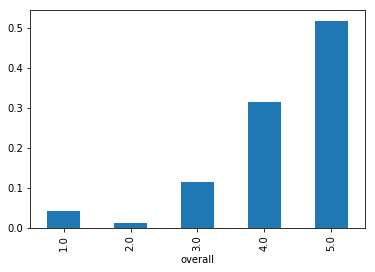

Histogram of Review Text Sentiment Scores for Incentivized Reviews


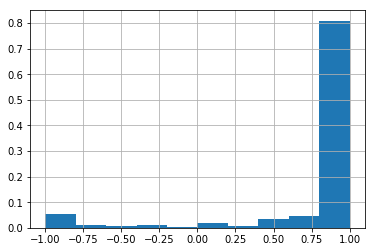

Frequency of Star Ratings of Non-Incentivized Reviews


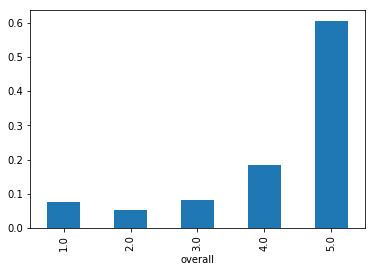

Histogram of Review Text Sentiment Score for Non-Incentivized Reviews


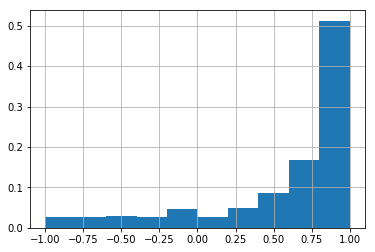

In [24]:
print('Frequency of Star Ratings of Incentivized Reviews')
(incentivized.groupby('overall').size()/incentivized.shape[0]).plot(kind = 'bar')
plt.show()
print('Histogram of Review Text Sentiment Scores for Incentivized Reviews')
incentivized['compound_score'].hist(weights = [1/incentivized.shape[0]]*incentivized.shape[0])
plt.show()
print('Frequency of Star Ratings of Non-Incentivized Reviews')

(non_incentivized.groupby('overall').size()/non_incentivized.shape[0]).plot(kind = 'bar')
plt.show()
print('Histogram of Review Text Sentiment Score for Non-Incentivized Reviews')

non_incentivized['compound_score'].hist(weights = [1/non_incentivized.shape[0]]*non_incentivized.shape[0])
plt.show()

There does indeed seem to be a difference in the way the sentiment scores and the reviews' overall scores are distributed. However the small size of this sample (only about 300 reviews) prevents us from drawing conclusions. We need to see if our findings still hold when looking at the whole dataset.

### Spark data pipeline

For the third and final milestone we ran our analysis on the whole dataset. The dataset we are working with is fairly large: the file containing reviews is approximately 90GB in size when uncompressed and the one containing product metadata is about 10GB large when uncompressed. The original data is encoded using JSON, which is inefficient in terms of space when storing structured data due to the need to repeat all column labels at every row. The size of the dataset made working with it on our laptops problematic, even when using small samples a few gigabytes in size.

The scripts we used to process the data with Spark are all in the `cluster_scripts` directory. `sample_data.py` and `get_metadata.py` were used during the initial analysis phase to retrieve samples small enough to work with locally, whereas all other scripts were used during this phase to work on the full dataset. Since we are working with structured data we used Spark dataframes wherever possible in order to allow Spark to perform additional optimizations.

* First of all the reviews are loaded from disk and preprocessed using `preprocess_reviews.py`. The reviews are stored as JSON objects, one per line, and can be parsed by using the Python json library. After parsing the script adds some additional items to each row, such as the sentiment score of the review's full text computed using Vader and the length of the review's text in words.

* Similarly, `preprocess_metadata.py` is used to load, parse, filter, and augment product metadata. The metadata for each product is also stored as one JSON object per line but it uses single quotes for strings instead of double quotes and so needs to be parsed using a different library. We added a main category and a price tier to each product just like we did in our exploratory analysis.

* After preprocessing we used `merge_reviews_metadata.py` to merge the outputs of the first two scripts into a single Spark dataframe.

* `filter_joined.py` loads the dataframe from the previous step and removes any rows where the price equals 0 (which means that the price was either absent from the metadata or it was originally 0) or to which we could not assign a main category. Both of these features will be used later on in our analysis so the rows in which their values are absent have to be removed.

* `bigrams.py` uses the process we showed above to add a list of bigrams of lemmatized words to each review.

* `filter_incentivized.py` extracts the incentivized reviews from the output of the previous step by using the list of bigrams defined above.

* `filter_electronics.py` extracts the reviews in the electronics category by looking at the meta-information of the product being reviewed. It is applied to both incentivized reviews and non incentivized reviews.

* `cluster_plots.py` computes the data for the plots that we used in the final analysis and then saves it to a json file. This data is small enough to be used on our laptops.

* After downloading the results of the computations from the cluster we used the code found in the notebook inside the `plots` folder to draw plots with Matplotlib.

### Results
We used bootstrap resampling in to determine 95% confidence intervals for all statistics in our plots. Bootstrap resampling is non-parametric and does not make any assumptions such as normality, simmetry, or absence of outliers on the distribution of the data. Due to the size of our data we were only able to use a limited number of bootstrap samples (10) even when using Spark. `cluster_plots.py` takes hours to run when using 7 executors with 8 cores each on the Spark cluster so using even 100 bootstrap samples would have been impractical.

We can say that when the confidence intervals of two statistics do not overlap they are significantly different.

![title](plots/comp_incent.png)

![title](plots/avg_compound_by_rating.png)

![title](plots/avg_length_by_overall.png)

### Conclusions and future work
In our analysis of this sample of amazon reviews we found that even though the authors of these reviews claim that they are being 'honest and unbiased' they are in fact not. Even though the difference in mean review score was minimal we have observed that the sentiment score and length of the reviews differ significantly, perhaps because reviewers who are provided with a free sample are more inclined to write a more positive review in the hopes that they will continue receiving goods for free.

Even though the incentivized reviews found in our analysis are a small fraction of the full dataset (207005 out of a total of 87292375) we still believe that this can represent an issue for the Amazon ecosystem. Amazon themselves acknowledged the issue and [banned incentivized reviews in 2016](https://blog.aboutamazon.com/innovation/update-on-customer-reviews). Our dataset only
has reviews written until 2014 so it is possible that the number of incentivized reviews increased between 2014 and 2016 and
caused amazon to ban this practice.

Future improvements to our work could focus on improved means of detecting incentivized reviews, perhaps through the use of machine learning, the analysis of more recent data, for example after the 2016 Amazon ban.